# Cong Workbook


In [ ]:
# QUESTION 1: JOIN - why did movie number increase post 2nd join? duplicates?
# QUESTION 2: similar question for second join 

### Import Libraries
Let's first import some stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install mysql-connector-python

In [3]:
import mysql.connector

In [4]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

### Loading SQL Queries

In [5]:
tn = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tn_movie_budgets""", con))

In [6]:
#Change data types
tn['domestic_gross'] = tn['domestic_gross'].str.replace('$','')  
tn['domestic_gross'] = tn['domestic_gross'].str.replace(',','')
tn['domestic_gross'] = tn['domestic_gross'].astype(float)
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace('$','')
tn['worldwide_gross'] =tn['worldwide_gross'].str.replace(',','')
tn['worldwide_gross'] =tn['worldwide_gross'].astype(float) 
tn['production_budget'] =tn['production_budget'].str.replace('$','')
tn['production_budget'] =tn['production_budget'].str.replace(',','')
tn['production_budget'] =tn['production_budget'].astype(float) 
tn['release_date'] = pd.to_datetime(tn['release_date'])

In [7]:
bom = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.bom_movie_gross""", con))

In [8]:
tmdb = pd.DataFrame(pd.read_sql_query("""
SELECT * 
FROM movies.tmdb_movies""", con))

In [9]:
tmd = pd.DataFrame(pd.read_sql_query("""
SELECT
	title,
    vote_average,
    popularity,
    release_date
FROM movies.tmdb_movies""", con))

In [10]:
tmd['release_date'] = pd.to_datetime(tmd['release_date'])

In [11]:
tmd = tmd.drop_duplicates(subset='title')

In [12]:
imdb_title_basics = pd.DataFrame(pd.read_sql_query("""
SELECT 
	primary_title,
    genres
FROM movies.imdb_title_basics""", con))

In [13]:
imdb_title_basics = imdb_title_basics.drop_duplicates(subset = 'primary_title')

In [302]:
# SELECT *
# FROM movies.imdb_title_basics
# JOIN movies.imdb_title_ratings USING (tconst)
#to compare ImDB genre to ratings 

In [303]:
# SELECT
# 	nconst,
#     tconst,
#     ordering,
#     category,
#     primary_title,
#     start_year,
#     genres,
#     primary_name,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_principals
# JOIN movies.imdb_title_basics USING (tconst)
# JOIN movies.imdb_name_basics USING (nconst)
# JOIN movies.imdb_title_ratings USING (tconst)
# WHERE start_year >= 2015
#to show which actresses / actors / directors appeared in most highly rated movies since 2015

In [304]:
# tn = pd.DataFrame(pd.read_sql_query("""
# SELECT Count(*)
# 	tconst,
#     primary_title,
#     averagerating,
#     numvotes
# FROM movies.imdb_title_ratings
# JOIN movies.imdb_title_basics USING (tconst)""", con))
# to join with tbi to get ratings vs. box office success correlation

### Approach 1 (NEW)

In [14]:
# JOIN bom and tn
tb = tn.join(bom.set_index('title'),
             on='movie',
             how='outer',
             lsuffix='_tn',
             rsuffix='_bom')

In [306]:
tb = tb.drop_duplicates(subset = 'movie')

In [307]:
# JOIN bom & tn and imdb_title_basics
tbi = tb.join(imdb_title_basics.set_index('primary_title'),
        on='movie',
        how='left',
        rsuffix='_imdb')

In [308]:
tbi = tbi.drop_duplicates(subset = 'movie')
tbi['domestic_gross_tn'] = np.where(tbi['domestic_gross_tn'].isna(), tbi['domestic_gross_bom'], tbi['domestic_gross_tn']) 
tbi = tbi.drop(columns=['domestic_gross_bom','studio'])
tbi[['genre1','genre2','genre3']] = tbi['genres'].str.split(pat=',',expand=True)
tbi['release_month'] = tbi['release_date'].dt.month
tbi = tbi.rename(columns={'production_budget':'production_budget_$m','domestic_gross_tn':'domestic_gross_$m','worldwide_gross':'worldwide_gross_$m', 'foreign_gross':'foreign_gross_$m'})

In [309]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].apply(lambda x: '{:.0f}'.format(x/1000000))

In [310]:
tbi['production_budget_$m'] = tbi['production_budget_$m'].astype(float)
tbi['domestic_gross_$m'] = tbi['domestic_gross_$m'].astype(float)
tbi['worldwide_gross_$m'] = tbi['worldwide_gross_$m'].astype(float)
tbi['foreign_gross_$m'] = tbi['foreign_gross_$m'].astype(float)

In [311]:
tbi['release_year'] = tbi['release_date'].dt.year
tbi['global_mom'] = tbi['worldwide_gross_$m'] / tbi['production_budget_$m']
tbi = tbi.round({'global_mom':2})

In [312]:
# JOIN tmd
tbi = tbi.join(tmd.set_index('title'),
         on='movie',
         how='left',
         rsuffix='_tmd')

In [313]:
tbi['release_date'] = np.where(tbi['release_date'].isna(), tbi['release_date_tmd'], tbi['release_date']) 

In [314]:
tbi = tbi.drop(columns=['release_date_tmd'])
tbi['release_year'] = tbi['release_date'].dt.year
tbi['release_month'] = tbi['release_date'].dt.month

In [315]:
tbi['worldwide_gross_$m'] = np.where(tbi['worldwide_gross_$m'].isna(), tbi['domestic_gross_$m'] + tbi['foreign_gross_$m'], tbi['worldwide_gross_$m'])

In [316]:
tbi.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7846 entries, 0.0 to nan
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    5698 non-null   float64       
 1   release_date          6829 non-null   datetime64[ns]
 2   movie                 7846 non-null   object        
 3   production_budget_$m  5698 non-null   float64       
 4   domestic_gross_$m     7820 non-null   float64       
 5   worldwide_gross_$m    6630 non-null   float64       
 6   foreign_gross_$m      2037 non-null   float64       
 7   year                  3386 non-null   float64       
 8   genres                3759 non-null   object        
 9   genre1                3759 non-null   object        
 10  genre2                2860 non-null   object        
 11  genre3                1865 non-null   object        
 12  release_month         6829 non-null   float64       
 13  release_year   

In [321]:
tbi.describe()

,id,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,year,release_month,release_year,global_mom,vote_average,popularity
count,5698.000000,5698.000000,7820.000000,6630.000000,2037.000000,3386.000000,6829.000000,6829.000000,5461.00,3055.000000,3055.00000
mean,50.320814,31.804844,33.240665,88.479638,74.856652,2013.957177,7.009372,2005.802021,inf,6.266252,9.15051
std,28.799762,41.987650,64.296219,173.661187,137.412644,2.477955,3.458334,11.827296,NaN,1.061256,7.15873
min,1.000000,0.000000,0.000000,0.000000,0.000000,2010.000000,1.000000,1916.000000,0.00,0.000000,0.60000
25%,25.000000,5.000000,0.000000,4.000000,4.000000,2012.000000,4.000000,2001.000000,0.56,5.700000,4.54000
50%,50.000000,17.000000,7.000000,25.000000,19.000000,2014.000000,7.000000,2009.000000,1.80,6.300000,8.00400
75%,75.000000,40.000000,39.000000,92.750000,75.000000,2016.000000,10.000000,2014.000000,3.86,7.000000,12.02450
max,100.000000,425.000000,937.000000,2776.000000,960.000000,2018.000000,12.000000,2020.000000,inf,10.000000,80.77300


### Execution

In [330]:
tbi_since1990 = tbi.loc[tbi['release_year'] > 1989]

In [332]:
tbi_since1990.groupby(['genre1']).mean()

,id,production_budget_$m,domestic_gross_$m,worldwide_gross_$m,foreign_gross_$m,year,release_month,release_year,global_mom,vote_average,popularity
genre1,,,,,,,,,,,
,44.608696,26.478261,39.250000,102.916667,117.000000,2014.454545,7.250000,2008.214286,inf,6.450000,7.267750
Action,50.511407,72.047529,63.713869,202.697674,157.623116,2013.974052,6.653623,2013.184058,inf,6.098229,13.654303
Adventure,47.758974,71.676923,73.824000,229.185841,173.897436,2014.129032,6.916335,2013.167331,3.041710,6.401852,12.479968
Animation,45.200000,51.400000,41.414634,155.774194,113.631579,2014.551724,7.658537,2012.365854,2.930500,6.691667,9.059333
Biography,49.400000,22.262069,19.849206,53.989362,38.483051,2014.583333,7.591270,2013.698413,inf,6.751082,8.605225
Comedy,52.622222,20.674074,21.937888,53.635458,34.598639,2013.412766,6.764341,2012.565891,inf,6.150172,8.055791
Crime,48.798246,23.429825,17.421384,48.214876,32.968750,2014.086538,7.260870,2012.645963,1.882569,6.219718,9.077556
Documentary,48.373984,19.008130,17.806931,44.854305,13.560976,2013.653061,6.867647,2010.313725,inf,6.798582,4.325206
Drama,49.968354,19.630802,15.640205,44.032258,30.268939,2013.976517,7.024328,2011.609475,inf,6.433181,7.234650


In [333]:
genre_vs_mom = tbi_since1990.groupby(['genre1']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [334]:
genre2_vs_mom = tbi_since1990.groupby(['genre2']).median().sort_values(by='global_mom',ascending=False)['global_mom']

In [325]:
genre_vs_mom

genre1
Mystery        4.450
War            3.210
Adventure      2.450
Animation      2.400
Horror         2.400
               2.340
Sci-Fi         2.190
Action         2.000
Musical        1.900
Biography      1.870
Comedy         1.850
Documentary    1.490
Drama          1.360
Fantasy        1.340
Thriller       1.040
Crime          1.000
Romance        0.835
Sport          0.830
Music          0.500
Western        0.120
Family         0.085
Name: global_mom, dtype: float64

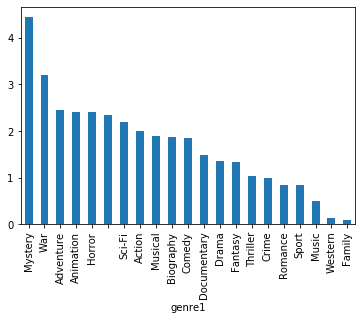

In [326]:
genre_vs_mom.plot.bar()

In [327]:
genre2_vs_mom

genre2
Mystery        2.920
Music          2.750
Animation      2.680
Adventure      2.470
Documentary    2.250
Romance        2.140
Sci-Fi         2.080
Comedy         2.050
Family         1.850
Fantasy        1.545
Drama          1.520
Crime          1.495
Horror         1.430
Thriller       1.390
Western        1.165
Sport          1.020
History        0.865
Biography      0.615
War            0.355
Musical          NaN
Name: global_mom, dtype: float64

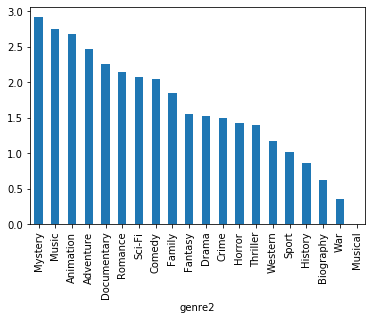

In [328]:
genre2_vs_mom.plot.bar()

### Notes

In [ ]:
# Use below three tables to do earnings / ROI by genre by season

In [ ]:
SELECT COUNT(*) 
FROM movies.imdb_title_basics
WHERE start_year > 2010
#total 146144 rows --> starts 2010 only 

In [ ]:
SELECT COUNT(*)
FROM movies.bom_movie_gross
# total 3387 rows --> total database only has 3387 rows and starts at 2010

In [ ]:
# tn movie budgets; bom movie gross; tmbd movies with unique titles 

In [ ]:
SELECT 
	COUNT(*),
    RIGHT(release_date, 4)
FROM movies.tn_movie_budgets
GROUP BY RIGHT(release_date, 4) ASC
#5782 rows total --> 1996 first year with over 100 movies 

SELECT 
	COUNT(*)
FROM movies.tn_movie_budgets
WHERE RIGHT(release_date, 4) > 1995
#4925
#2194 for 2010 and after

In [1]:
#GENERAL Analysis (JOIN ON Movie name)
#earnings / ROI by genre (tn_movie_budgets + imdb_title_basics JOIN on movie title) POST 2010 (only 2194 movies)
#earnings / ROI by season (use only tn_movie_budgets) POST 2010 (only 2194 movies)
#ratings vs. box office success correlatoin (movie_budgets and title_basics)
#IMDB analysis (JOIN ON nmstat and tstat)
#imdb genre vs. rating (use title_basics, title_ratings JOIN on tconst) POST 2010 (limit is ratings)
#imdb actors, directors and producers with highest ratings (use title_principals, title_ratings and 
#name_basics, JOIN on tconst and nmconst) POST 2010 (limit is ratings)
#RT Analysis (JOIN ON ID)
#overview of top critics, most frequent critics and what genres they like / how harsh they are (rt_reviews)
#rt ratings vs. box office reviews vs. top critics (1500 instances approx) limited by box office numbers in movie_info

In [ ]:
# LIST of databases
## DONT USE movies.bom_movie_gross for anything 
## DONT USE movies.imdb_name basics
## DONT USE imdb title akas
## DONT USE imdb title crew
## ONLY database with too many rows is imdb principles w/ over 1m 

In [ ]:
# TO DO
## Split genre into Primary, Secondary, Tertiary (for both ImDB and RT)